# Example of using the PyRadiomics toolbox in Python

First, import some built-in Python modules needed to get our testing data.
Second, import the toolbox, only the `featureextractor` is needed, this module handles the interaction with other parts of the toolbox.

In [1]:
from __future__ import print_function
import six
import glob, os, sys  # needed navigate the system to get the input data
import time

# features are described at https://pyradiomics.readthedocs.io/en/latest/features.html
import radiomics
from radiomics import featureextractor  # This module is used for interaction with pyradiomics

import SimpleITK as sitk
import numpy as np
import pandas as pd
import cv2

# Display the images
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

import seaborn as sns
print(f'seaborn version = {sns.__version__}')

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.utils import shuffle

seaborn version = 0.11.1


In [2]:
ARG_SOURCE_PATH='/hdd/data/radioterapia/ciolaplata'

# ARG_DICOM_AND_GAMMA_CSV = "codex.2019-2018-2017.3mm3%Doseshift10%-localnorm-sinoutliers74.csv" # 7244 casos
ARG_DICOM_AND_GAMMA_CSV = "codex.2019-2017.3mm3%Doseshift10%-localnorm-sinoutliers74.csv" # 4268 casos

ARG_TEXTURE_FEATURES_CSV='2019-2018-2017.radiomics-glcmsep-contours-threshold25.csv'
ARG_TEXTURE_FEATURES_CSV='2019-2018-2017.radiomics[original,wavelet].glcmsep.contours_threshold25.csv'
ARG_TEXTURE_FEATURES_CSV='2019-2017.radiomics[original,wavelet].glcmsep.contours_threshold25.csv'

ARG_SEED=23456 # t-SNE

# example image to extract features from
# image_filename = '2017-opencv-jpeg/1.3.6.1.4.1.9590.100.1.2.104687111612620525338811872261145275128.jpeg' # 1 contour
# image_filename = '2017-opencv-jpeg/1.3.6.1.4.1.9590.100.1.2.413026936412366497424912997123899479271.jpeg' # 1 contour
# image_filename = '2017-opencv-jpeg/1.3.6.1.4.1.9590.100.1.2.149022879910701913634657645393318300150.jpeg' # 3 contours with thres = 25, 2 with thres = 20
# image_filename = '2017-opencv-jpeg/1.3.6.1.4.1.9590.100.1.2.68178121113821334525403915874018401462.jpeg' # 4 contours with thres = 25, 1 with thres = 20
image_filename = '2017-opencv-jpeg/1.3.6.1.4.1.9590.100.1.2.76296562210273102234514513081279675861.jpeg' # 3 contours with thres = 25, 1 also with thres = 20
# image_filename = '2017-opencv-jpeg/1.3.6.1.4.1.9590.100.1.2.416170821113456993519232191293830059931.jpeg'

# images with large number of contours computed with threshold = 25
# image_filename = '2018-opencv-jpeg/1.3.6.1.4.1.9590.100.1.2.74512815511852542732408311143041074432.jpeg'
# image_filename = '2018-opencv-jpeg/1.3.6.1.4.1.9590.100.1.2.62640114011543701236144234712559997173.jpeg'
# image_filename = '2018-opencv-jpeg/1.3.6.1.4.1.9590.100.1.2.141504918511005072804737212242987163148.jpeg'
# image_filename = '2017-opencv-jpeg/1.3.6.1.4.1.9590.100.1.2.267686204211648952638500391850390683521.jpeg'
# image_filename = '2019-opencv-jpeg/1.3.6.1.4.1.9590.100.1.2.179128525612273979528635583091258518774.jpeg'
# image_filename = '2018-opencv-jpeg/1.3.6.1.4.1.9590.100.1.2.34398218812284801316473676151812241724.jpeg'
# image_filename = '2017-opencv-jpeg/1.3.6.1.4.1.9590.100.1.2.225757162312921485327595334411274565978.jpeg'

imagePath = os.path.join(ARG_SOURCE_PATH, image_filename)

ARG_EXTRACT_FEATURES=True
ARG_THRESHOLD = 25

### Setting up data

In [3]:
os.getcwd()

'/home/pablo/dev/radioterapia/fluence_maps/radiomics'

### Create dumb mask including _almost_ all pixels
If all pixels are included (0, 0, 255, 255) the mask is not created, so I created a (1, 1, 254, 254) mask.

In [4]:
def createDumbMask(image) -> sitk.SimpleITK.Image:
    image_size = image.GetSize()[::-1]
    point = (int(image_size[0]/2), int(image_size[1]/2))  # fill in the index of your point here
    # (254, 254) excluyo 1 pixel de cada lado
    roi_size = (image_size[0]-2, image_size[1]-2)  # x, y, z; uneven to ensure the point is really the center of your ROI

    ma_arr = np.zeros(image_size, dtype='uint8')

    # Compute lower and upper bound of the ROI
    L_x = point[0] - int((roi_size[0]) / 2)
    L_y = point[1] - int((roi_size[1]) / 2)

    U_x = point[0] + int((roi_size[0] - 1) / 2)
    U_y = point[1] + int((roi_size[1] - 1) / 2)

    # ensure the ROI stays within the image bounds
    L_x = max(0, L_x)
    L_y = max(0, L_y)

    U_x = min(image_size[1] - 1, U_x)
    U_y = min(image_size[0] - 1, U_y)

    print(L_x, L_y, U_x, U_y)

    # 'segment' the mask
    ma_arr[L_y:U_y + 1, L_x:U_x+1] = 1  # Add + 1 to each slice, as slicing is done from lower bound to, but not including, upper bound. Because we do want to include our upper bound, add + 1
    print(ma_arr)

    ma = sitk.GetImageFromArray(ma_arr)
    ma.CopyInformation(image)  # This copies the geometric information, ensuring image and mask are aligned. This works, because image and mask have the same size of the pixel array

    # we don't need to write the image, we can pass a SimpleITK Image to the extractor
    #sitk.WriteImage(ma, maskPath, True)  # don't forget the extension!, True specifies it can be compressed for storage (only used for masks
    return ma

### Create mask from countours

In [5]:
def createMaskFromContours(imagePath, debug=False) -> sitk.SimpleITK.Image:
    image = cv2.imread(imagePath) 

    # Finding Contours 
    # Use a copy of the image e.g. imgray.copy() since findContours alters the image 
    imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Second output is our thresholded image.
    # 20 is threshold, 255 is max value
    ret, thresh = cv2.threshold(imgray, ARG_THRESHOLD, 255, 0)

    # contours is a Python list of all the contours in the image.
    # Each individual contour is a Numpy array of (x,y) coordinates of boundary points of the object.
    image, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    assert len(contours) != 0.0, f"Number of contour for image {imagePath} is zero."
    
    # for debugging only
    if debug:
        print(imagePath)
        print("Number of Contours found = " + str(len(contours)))
        plt.imshow(image, cmap = 'gray')

    ma_arr = image
    ma_arr = np.where(ma_arr == 255, 1, ma_arr)

    ma = sitk.GetImageFromArray(ma_arr)

    # we don't need to write the image, we can pass a SimpleITK Image to the extractor
    # sitk.WriteImage(ma, maskPath, True)
    return ma

### Create bounding rectangle mask

In [6]:
# A bounding rectangle mask is of little use when extracting features with pyradiomics, because pyradiomics supports
# any mask so we use countour masks.
def createBoundingRectangleMask(imagePath, debug=False) -> sitk.SimpleITK.Image:
    image = cv2.imread(imagePath) 

    # Finding Contours 
    # Use a copy of the image e.g. imgray.copy() since findContours alters the image 
    imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Second output is our thresholded image.
    # 20 is threshold, 255 is max value
    ret, thresh = cv2.threshold(imgray, ARG_THRESHOLD, 255, 0)

    # contours is a Python list of all the contours in the image.
    # Each individual contour is a Numpy array of (x,y) coordinates of boundary points of the object.
    image2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    assert len(contours) != 0.0, f"Number of contour for image {imagePath} is zero."
    
    # tomar el contorno de área máxima
    # loop over the contours
    cnt = contours[0]
    for i in range(0, len(contours)):
        if cv2.contourArea(contours[i]) > cv2.contourArea(cnt):
            cnt = contours[i]
            
    x,y,w,h = cv2.boundingRect(cnt)
    bounding_box_area = w*h
    assert bounding_box_area != 0.0, f"Bounding box area for image {imagePath} is zero."

    # image2.shape = (256, 256)
    ma_arr = np.zeros(image2.shape, dtype='uint8')
    ma_arr[y:y+h, x:x+w] = 1
    ma = sitk.GetImageFromArray(ma_arr)
    
    # for debugging only
    if debug:
        print(imagePath)
        print("Number of Contours found = " + str(len(contours)))
        print(f"Bounding rectangle (x={x}, y={y}, w={w}, h={h})")

        plt.figure(figsize=(12, 12))

        plt.subplot(1,2,1)
        plt.imshow(image2, cmap = 'gray')
        plt.title("Contour mask")

        plt.subplot(1,2,2)
        cv2.rectangle(imgray, (x,y), (x+w,y+h), (128,0,0), 2)
        plt.imshow(imgray, cmap = 'gray')
        plt.title(f"Fluence map with bounding rectangle")

    # we don't need to write the image, we can pass a SimpleITK Image to the extractor
    # sitk.WriteImage(ma, maskPath, True)
    return ma

### Crop image to bounding rectangle

In [7]:
# Use when extracting GLCM features using scikit-image only, not with pyradiomics
def cropToBoundingRectangle(imagePath, debug=False):
    image = cv2.imread(imagePath) 

    # Finding Contours 
    # Use a copy of the image e.g. imgray.copy() since findContours alters the image 
    imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Second output is our thresholded image.
    # 20 is threshold, 255 is max value
    ret, thresh = cv2.threshold(imgray, ARG_THRESHOLD, 255, 0)

    # contours is a Python list of all the contours in the image.
    # Each individual contour is a Numpy array of (x,y) coordinates of boundary points of the object.
    image2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    assert len(contours) != 0.0, f"Number of contour for image {imagePath} is zero."
    
    # tomar el contorno de área máxima
    # loop over the contours
    cnt = contours[0]
    for i in range(0, len(contours)):
        if cv2.contourArea(contours[i]) > cv2.contourArea(cnt):
            cnt = contours[i]
            
    x,y,w,h = cv2.boundingRect(cnt)
    bounding_box_area = w*h
    assert bounding_box_area != 0.0, f"Bounding box area for image {imagePath} is zero."

    # crop the image and make a copy of it before drawing the rectangle with cv2.rectangle()
    cropped_image = imgray[y:y+h, x:x+w].copy()
    
    # for debugging only
    if debug:
        print(imagePath)
        print("Number of Contours found = " + str(len(contours)))
        print(f"Bounding rectangle (x={x}, y={y}, w={w}, h={h})")

        plt.figure(figsize=(12, 12))

        plt.subplot(1,3,1)
        plt.imshow(image2, cmap = 'gray')
        plt.title(f"Contour mask {image2.shape}")

        plt.subplot(1,3,2)
        cv2.rectangle(imgray, (x,y), (x+w,y+h), (128,0,0), 2)
        plt.imshow(imgray, cmap = 'gray')
        plt.title(f"Fluence map\nwith bounding rectangle {imgray.shape}")

        plt.subplot(1,3,3)
        plt.imshow(cropped_image, cmap = 'gray')
        plt.title(f"Fluence map cropped\nto bounding rectangle {cropped_image.shape}")

    return cropped_image

In [8]:
# cropped_image = cropToBoundingRectangle(imagePath, True)

### Cell to play/experiment: find contours, find bounding rectangle, crop image, etc...
For experimentation: cv2.threshold() parameters differ from those in createMaskFromContours()

Contour features:
	Number of contours found = 3
	Contour area = 11041.5
	Bouding box area = 14832
	Contour perimeter = 597.203
	Convex hull area = 12807.0
	Extent = 0.7444377022653722
	Solidity = 0.8621457015694542
	Bounding rectangle (x=78, y=66, w=103, h=144)
(144, 103)


Text(0.5, 1.0, 'Fluence map cropped\nto bounding rectangle (w=103, h=144)')

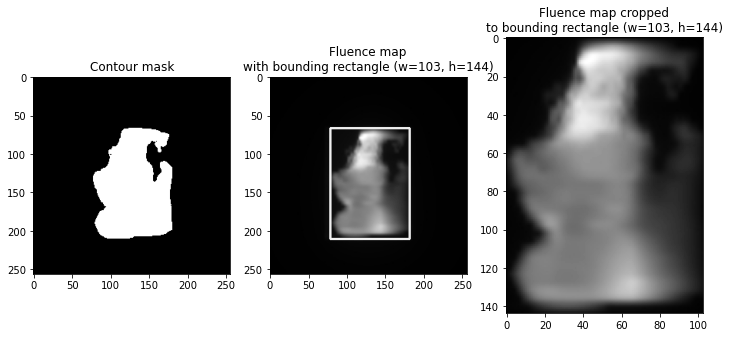

In [9]:
image = cv2.imread(imagePath) # (256, 256, 3)

# Finding Contours 
# Use a copy of the image e.g. imgray.copy() since findContours alters the image 
imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # (256, 256, 3)

# Second output is our thresholded image.
# 25 is threshold, 255 is max value
ret, thresh = cv2.threshold(imgray, ARG_THRESHOLD, 255, 0)

# contours is a Python list of all the contours in the image.
# Each individual contour is a Numpy array of (x,y) coordinates of boundary points of the object.
image2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# image2.shape = (256, 256)

# tomar el contorno de área máxima
# loop over the contours
cnt = contours[0]
for i in range(0, len(contours)):
    if cv2.contourArea(contours[i]) > cv2.contourArea(cnt):
        cnt = contours[i]

x,y,w,h = cv2.boundingRect(cnt)

print("Contour features:")
contour_area = cv2.contourArea(cnt)
contour_perimeter = cv2.arcLength(cnt, True)
hull = cv2.convexHull(cnt)
hull_area = cv2.contourArea(hull)
# extent = contour area / bounding box area
bounding_box_area = w*h
extent = contour_area / float(bounding_box_area)
# solidity = contour area / convex hull area
if hull_area != 0:
    solidity = contour_area / float(hull_area)

print(f"\tNumber of contours found = {len(contours)}")
print(f"\tContour area = {contour_area}")
print(f"\tBouding box area = {bounding_box_area}")
print(f'\tContour perimeter = {contour_perimeter:.3f}')
print(f'\tConvex hull area = {hull_area}')
print(f'\tExtent = {extent}')
print(f'\tSolidity = {solidity}')
print(f"\tBounding rectangle (x={x}, y={y}, w={w}, h={h})")


# crop the image and make a copy of it before drawing the rectangle with cv2.rectangle()
cropped_image = imgray[y:y+h, x:x+w].copy()
print(cropped_image.shape)

# draw a rectangle in the image
cv2.rectangle(imgray,(x,y),(x+w,y+h), (240,0,0),2)

plt.figure(figsize=(12, 12))

plt.subplot(1,3,1)
plt.imshow(image2, cmap = 'gray')
plt.title(f"Contour mask")

plt.subplot(1,3,2)
plt.imshow(imgray, cmap = 'gray')
plt.title(f"Fluence map\nwith bounding rectangle (w={w}, h={h})")

plt.subplot(1,3,3)
plt.imshow(cropped_image, cmap = 'gray')
plt.title(f"Fluence map cropped\nto bounding rectangle (w={cropped_image.shape[1]}, h={cropped_image.shape[0]})")

In [10]:
len(image2)

256

In [11]:
# contours
print(len(contours))
# loop over the contours
for i in range(0, len(contours)):
    area = cv2.contourArea(contours[i])
    print(area)

3
11041.5
4.0
2.0


### Show the images

Using `matplotlib.pyplot` (referenced as `plt`), display the images in grayscale and labels in color.

(256, 256)
/hdd/data/radioterapia/ciolaplata/2017-opencv-jpeg/1.3.6.1.4.1.9590.100.1.2.76296562210273102234514513081279675861.jpeg
Number of Contours found = 3
(256, 256)


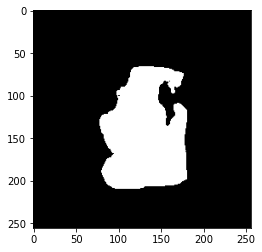

In [12]:
image_1 = sitk.ReadImage(imagePath)
# [::-1] es iterable[inicio:fin:paso]
image_size = image_1.GetSize()[::-1]  # size in z, y, x, needed because the arrays obtained from the image are oriented in z, y, x
print(image_size)

label_1 = createMaskFromContours(imagePath, debug=True)
image_size = label_1.GetSize()[::-1]
print(image_size)

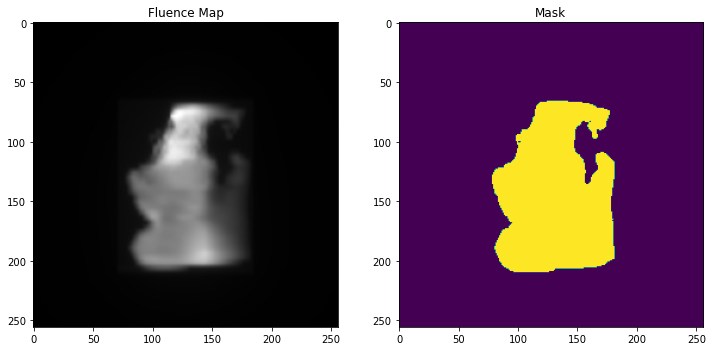

In [13]:
plt.figure(figsize=(12,12))

# 1 row, 2 columns, plot 1
plt.subplot(1,2,1)
plt.imshow(sitk.GetArrayFromImage(image_1)[:,:], cmap="gray")
plt.title("Fluence Map")
# 1 row, 2 columns, plot 2
plt.subplot(1,2,2)
plt.imshow(sitk.GetArrayFromImage(label_1)[:,:])        
plt.title("Mask")

plt.show()

## Extract the features

Using the `radiomics` package, first construct an `extractor` object from the parameters set in `Params.yaml`.  Then generate features for the two images.

In [14]:
# Additonally, store the location of the example parameter file, stored in \pyradiomics\examples/exampleSettings
paramPath = os.path.join('.', 'rtParams.yaml')
print('Parameter file, absolute path:', os.path.abspath(paramPath))

Parameter file, absolute path: /home/pablo/dev/radioterapia/fluence_maps/radiomics/rtParams.yaml


### Instantiating the extractor

Now that we have our input, we need to define the parameters and instantiate the extractor.
For this there are three possibilities:

1. Use defaults, don't define custom settings

2. Define parameters in a dictionary, control filters and features after initialisation

3. Use a parameter file

##### Method 3, using a parameter file

In [15]:
# radiomics.setVerbosity(10) # 10: Log messages of level “DEBUG” and up are printed (i.e. all log messages)

# Instantiate the extractor
extractor = featureextractor.RadiomicsFeatureExtractor(paramPath)

print('Extraction parameters:\n\t', extractor.settings)
print('Enabled filters:\n\t', extractor.enabledImagetypes)
print('Enabled features:\n\t', extractor.enabledFeatures)

Extraction parameters:
	 {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1, 2, 4, 8], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True, 'binWidth': 16, 'weightingNorm': None}
Enabled filters:
	 {'Original': {}, 'Wavelet': {}}
Enabled features:
	 {'firstorder': ['10Percentile', '90Percentile', 'Energy', 'Entropy', 'InterquartileRange', 'Kurtosis', 'MeanAbsoluteDeviation', 'Mean', 'Range', 'RobustMeanAbsoluteDeviation', 'RootMeanSquared', 'Skewness', 'TotalEnergy', 'Uniformity', 'Variance'], 'glcm': ['Autocorrelation', 'JointAverage', 'ClusterProminence', 'ClusterShade', 'ClusterTendency', 'Contrast', 'Correlation', 'DifferenceAverage', 'DifferenceEntropy', 'DifferenceVariance', 'JointEnergy', 'JointEntropy', 'Imc1', 'Imc2', 'Idm', 'MCC', 'Idmn', 'Id', 'Idn', 

### Extract features using pyradiomics

Now that we have our extractor set up with the correct parameters, we can start extracting features:

In [16]:
# imageFilepath – SimpleITK Image, or string pointing to image file location
# maskFilepath – SimpleITK Image, or string pointing to labelmap file location
result = extractor.execute(image_1, label_1)

In [17]:
print('Result type:', type(result))  # result is returned in a Python ordered dictionary)
print('')
print('Calculated features')
for key, value in six.iteritems(result):
    print('\t', key, ':', value)

Result type: <class 'collections.OrderedDict'>

Calculated features
	 diagnostics_Versions_PyRadiomics : v3.0.1
	 diagnostics_Versions_Numpy : 1.19.2
	 diagnostics_Versions_SimpleITK : 2.0.2
	 diagnostics_Versions_PyWavelet : 1.1.1
	 diagnostics_Versions_Python : 3.7.5
	 diagnostics_Configuration_Settings : {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1, 2, 4, 8], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True, 'binWidth': 16, 'weightingNorm': None}
	 diagnostics_Configuration_EnabledImageTypes : {'Original': {}, 'Wavelet': {}}
	 diagnostics_Image-original_Hash : 46c2c339dd445893169754d3fc1d9a95b53fbef6
	 diagnostics_Image-original_Dimensionality : 2D
	 diagnostics_Image-original_Spacing : (1.0, 1.0)
	 diagnostics_Image-original_Size : (256, 256)
	 diag

### Extract GLCM features using scikit-image

In [18]:
# The GLCM Tutorial Home Page,
#       http://www.fp.ucalgary.ca/mhallbey/tutorial.htm       
from skimage.feature import greycomatrix, greycoprops
from skimage import io  

image = io.imread(imagePath)

xs = []
ys = []
# Todas las métricas para las distintas distancias están correlacionadas con r > 0.9, entonces sólo uso d = 5
# las métrics 'energy' y 'ASM' tienen una correlación r = 1.0 para todas las distancias y todos los ángulos, entonces sólo uso d = 5 y a = 0
# distances = [1, 2, 4, 8] # d: list of pixel pair distance offsets.
distances = [5]
angles = [0, np.pi*1/4, np.pi*2/4, np.pi*3/4] # a: list of pixel pair angles in radians. Para todas las métricas excepto 'energy' y 'ASM'
a_degress = (np.array(angles)*180/np.pi).astype(np.int)
glcm = greycomatrix(image, distances=distances, angles=angles, levels=256,
                    symmetric=True, normed=True)
xs.append(greycoprops(glcm, 'dissimilarity')[0, 0])
ys.append(greycoprops(glcm, 'correlation')[0, 0])

In [19]:
glcm[:, :, 0, 3].shape

(256, 256)

In [20]:
# results : 2-D ndarray
#    2-dimensional array. `results[d, a]` is the property 'prop' for
#    the d'th distance and the a'th angle.
# ex.: results[2, 1] is results[d=4, a=45]
greycoprops(glcm, 'dissimilarity')

array([[4.22592443, 4.9877803 , 3.71341198, 4.64351852]])

In [21]:
def extract_gclm_separated(image):
    '''
    I stop computing features across the whole image, but in the bounding rectangle.
    '''
    distances = [5] # d: list of pixel pair distance offsets.
    angles = [0, np.pi*1/4, np.pi*2/4, np.pi*3/4] # a: list of pixel pair angles in radians.
    a_degress = (np.array(angles)*180/np.pi).astype(np.int)
    
    # la matriz se calcula para todas las distancias y ángulos,
    # pero las métricas no, sólo para las distancias y ángulos de interés.
    glcm = greycomatrix(image, distances=distances, angles=angles, levels=256,
                        symmetric=True, normed=True)
    
    glcm_dict = {}
    features = ['contrast', 'dissimilarity', 'homogeneity', 'correlation']
    for f_name in features:
        m = greycoprops(glcm, f_name)
        for d in range(0, len(distances)):
            for a in range(0, len(angles)):
                name = 'glcmsep_'+f_name+'_'+str(distances[d])+'_'+str(a_degress[a])
                glcm_dict[name] = m[d, a]
                
    
    angles = [0]
    a_degress = (np.array(angles)*180/np.pi).astype(np.int)
    
    features = ['energy', 'ASM']
    for f_name in features:
        m = greycoprops(glcm, f_name)
        for d in range(0, len(distances)):
            for a in range(0, len(angles)):
                name = 'glcmsep_'+f_name+'_'+str(distances[d])+'_'+str(a_degress[a])
                glcm_dict[name] = m[d, a]
                
    return glcm_dict

In [22]:
glcm_dict=extract_gclm_separated(cropToBoundingRectangle(imagePath))
print('Se extrajeron {} GCLM features separadas calculadas en el bounding rectangle.'.format(len([*glcm_dict]))) # https://www.python.org/dev/peps/pep-0448/
glcm_dict

Se extrajeron 18 GCLM features separadas calculadas en el bounding rectangle.


{'glcmsep_contrast_5_0': 688.8456632653061,
 'glcmsep_contrast_5_45': 995.9274891774885,
 'glcmsep_contrast_5_90': 660.1728015645735,
 'glcmsep_contrast_5_135': 799.8394660894654,
 'glcmsep_dissimilarity_5_0': 16.926020408163268,
 'glcmsep_dissimilarity_5_45': 19.53672438672436,
 'glcmsep_dissimilarity_5_90': 14.051267723685124,
 'glcmsep_dissimilarity_5_135': 17.975541125541113,
 'glcmsep_homogeneity_5_0': 0.12431903124856161,
 'glcmsep_homogeneity_5_45': 0.10797103118995947,
 'glcmsep_homogeneity_5_90': 0.18619666529952492,
 'glcmsep_homogeneity_5_135': 0.14334022321892545,
 'glcmsep_correlation_5_0': 0.9064911001861282,
 'glcmsep_correlation_5_45': 0.8643676018596037,
 'glcmsep_correlation_5_90': 0.9116283004677695,
 'glcmsep_correlation_5_135': 0.8910653077227173,
 'glcmsep_energy_5_0': 0.027465185623984537,
 'glcmsep_ASM_5_0': 0.0007543364213599269}

In [23]:
def extractContourFeatures(imagePath):
    feat_dict = {}
    
    image = cv2.imread(imagePath) 

    # Finding Contours 
    # Use a copy of the image e.g. imgray.copy() since findContours alters the image 
    imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Second output is our thresholded image.
    # 20 is threshold, 255 is max value
    ret, thresh = cv2.threshold(imgray, 25, 255, 0)

    # contours is a Python list of all the contours in the image.
    # Each individual contour is a Numpy array of (x,y) coordinates of boundary points of the object.
    image2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    assert len(contours) != 0.0, f"Number of contour for image {imagePath} is zero."
    
    # tomar el contorno de área máxima
    # loop over the contours
    cnt = contours[0]
    for i in range(0, len(contours)):
        if cv2.contourArea(contours[i]) > cv2.contourArea(cnt):
            cnt = contours[i]
        
    x,y,w,h = cv2.boundingRect(cnt)

    contour_area = cv2.contourArea(cnt)
    contour_perimeter = cv2.arcLength(cnt, True)
    hull = cv2.convexHull(cnt)
    hull_area = cv2.contourArea(hull)
    assert hull_area != 0.0, f"Convex hull area for image {imagePath} is zero."
    bounding_box_area = w*h
    assert bounding_box_area != 0.0, f"Bounding box area for image {imagePath} is zero."
    # extent = contour area / bounding box area
    extent = contour_area / float(bounding_box_area)
    # solidity = contour area / convex hull area
    if hull_area != 0:
        solidity = contour_area / float(hull_area)
    
    feat_dict = {
        'contour_number' : len(contours)
        , 'contour_area' : contour_area
        , 'contour_perimeter' : contour_perimeter
        , 'contour_bounding_box_area' : bounding_box_area
        , 'contour_hull_area' : hull_area
        , 'contour_extent' : extent
        , 'contour_solidity' : solidity
    }
    
    return feat_dict

In [24]:
contour_dict=extractContourFeatures(imagePath)
print('Se extrajeron {} contour features.'.format(len([*contour_dict])))
contour_dict

Se extrajeron 7 contour features.


{'contour_number': 3,
 'contour_area': 11041.5,
 'contour_perimeter': 597.203097820282,
 'contour_bounding_box_area': 14832,
 'contour_hull_area': 12807.0,
 'contour_extent': 0.7444377022653722,
 'contour_solidity': 0.8621457015694542}

In [25]:
def getFeatureNames(result, glcm_dict, contour_dict):
    # tomar los keys del diccionario result que empiezan con 'original_'
    # y armar una lista, las que van a ser las columnas del dataframe de features
    # feature_names = [key[len('original_'):] for key in result.keys() if key.startswith('original_')]
    # le dejo el prefijo 'original_' y se lo saco después
    feature_names = [key for key in result.keys() if not key.startswith('diagnostics_')]
    feature_names = feature_names + [*glcm_dict] + [*contour_dict]
    return feature_names

In [26]:
def getRenamedFeatureNames(result, glcm_dict, contour_dict):
    # tomar los keys del diccionario result que empiezan con 'original_'
    # y armar una lista, las que van a ser las columnas del dataframe de features
    # remuevo el prefijo 'original_'
    feature_names = [key for key in result.keys() if not key.startswith('diagnostics_')]
    feature_names = feature_names + [*glcm_dict] + [*contour_dict]
    return feature_names

In [27]:
renamed_feature_names = getRenamedFeatureNames(result, glcm_dict, contour_dict)
renamed_feature_names

['original_firstorder_10Percentile',
 'original_firstorder_90Percentile',
 'original_firstorder_Energy',
 'original_firstorder_Entropy',
 'original_firstorder_InterquartileRange',
 'original_firstorder_Kurtosis',
 'original_firstorder_MeanAbsoluteDeviation',
 'original_firstorder_Mean',
 'original_firstorder_Range',
 'original_firstorder_RobustMeanAbsoluteDeviation',
 'original_firstorder_RootMeanSquared',
 'original_firstorder_Skewness',
 'original_firstorder_TotalEnergy',
 'original_firstorder_Uniformity',
 'original_firstorder_Variance',
 'original_glcm_Autocorrelation',
 'original_glcm_JointAverage',
 'original_glcm_ClusterProminence',
 'original_glcm_ClusterShade',
 'original_glcm_ClusterTendency',
 'original_glcm_Contrast',
 'original_glcm_Correlation',
 'original_glcm_DifferenceAverage',
 'original_glcm_DifferenceEntropy',
 'original_glcm_DifferenceVariance',
 'original_glcm_JointEnergy',
 'original_glcm_JointEntropy',
 'original_glcm_Imc1',
 'original_glcm_Imc2',
 'original_glc

## Extract features for each .jpeg file in folder and generate .csv with features

In [28]:
def build_jpeg_filename(base, year, filename):
    return os.path.join(base, year + '-opencv-jpeg', filename + '.jpeg')

In [29]:
def extractFeatures(df):
    total = len(df)
    i = 0
    for file in df['jpeg_full_filepath'].values:
        try:
            image = sitk.ReadImage(file)
            shape = image.GetSize()[::-1]
            assert len(shape) == 2, "JPEG files are not grey level (i.e.: do not have 2 channels)"
            assert shape[0] == 256 and shape[1] == 256, "JPEG files are not of size 256x256"

            # generar la máscara para cada imagen
            mask = createMaskFromContours(file)
            
            result = extractor.execute(image, mask)
            for key in result.keys():
                if not key.startswith('diagnostics_'):
                    df.loc[i, key] = result.get(key)

            # read image file again using scikit-image
            image = io.imread(file)
            glcm_dict=extract_gclm_separated(cropToBoundingRectangle(file))
            for key in glcm_dict.keys():
                df.loc[i, key] = glcm_dict.get(key)
                    
            contour_dict = extractContourFeatures(file)
            for key in contour_dict.keys():
                df.loc[i, key] = contour_dict.get(key)
                        
            sys.stdout.write('\r>> Features extracted for image %d/%d.' % (i+1, total))
            sys.stdout.flush()
            i += 1

        except OSError as err:
            print('Could not extract features for file {}, error: {}'.format(file, err))

    sys.stdout.write('\n')
    sys.stdout.flush()
    
    return df

In [30]:
if ARG_EXTRACT_FEATURES:
    source_folder = ARG_SOURCE_PATH

    gamma_csv = os.path.join(source_folder, ARG_DICOM_AND_GAMMA_CSV)
    texture_features_csv = os.path.join(ARG_SOURCE_PATH, ARG_TEXTURE_FEATURES_CSV)
    df_dcm_in = pd.read_csv(gamma_csv, sep=';', delimiter=None, header=0)
    N = len(df_dcm_in)
    feature_names = getFeatureNames(result, glcm_dict, contour_dict)
    print("Se extraerán {} features para cada uno de los {} archivos JPEG en {}, y se escribirán en {}."
          .format(len(feature_names), N, gamma_csv, texture_features_csv))

    # agrego una columna constante al dataframe para hacer más simple el armado del full file path de los archivos dicom
    df_dcm_in['base_dir'] = source_folder

    df_features_out = pd.DataFrame(columns=['jpeg_full_filepath', 'gamma_index'] + feature_names)
    df_features_out['jpeg_full_filepath'] = [build_jpeg_filename(row[0], str(row[1]), row[2]) for row in df_dcm_in[['base_dir', 'año', 'fluencia calculada']].values]
    df_features_out['gamma_index'] = df_dcm_in.apply(lambda row: 100.0 - row['uno menos gamma index'], axis=1)

    # extract features
    df_features = extractFeatures(df_features_out)

    df_features.columns= ['jpeg_full_filepath', 'gamma_index'] + renamed_feature_names

    df_features.to_csv(texture_features_csv, index=False)
    print(f'Texture features .csv file saved to {texture_features_csv}.\n')

Se extraerán 470 features para cada uno de los 4268 archivos JPEG en /hdd/data/radioterapia/ciolaplata/codex.2019-2017.3mm3%Doseshift10%-localnorm-sinoutliers74.csv, y se escribirán en /hdd/data/radioterapia/ciolaplata/2019-2017.radiomics[original,wavelet].glcmsep.contours_threshold25.csv.
>> Features extracted for image 271/4268.

/home/pablo/anaconda3/envs/radioterapia/lib/python3.7/site-packages/radiomics/glcm.py:599: RuntimeWarning: invalid value encountered in sqrt
  imc2 = (1 - numpy.e ** (-2 * (HXY2 - HXY))) ** 0.5


>> Features extracted for image 4268/4268.
Texture features .csv file saved to /hdd/data/radioterapia/ciolaplata/2019-2017.radiomics[original,wavelet].glcmsep.contours_threshold25.csv.



## Load features from .csv

In [31]:
def gamma_interval(gamma_value):
    if gamma_value < 95.0:
        interval = "< 95%"
    elif gamma_value >= 95.0:
        interval = ">= 95%"
    
    return interval

In [32]:
texture_features_csv = os.path.join(ARG_SOURCE_PATH, ARG_TEXTURE_FEATURES_CSV)
df_features_copy = pd.read_csv(texture_features_csv, delimiter=None, header=0)
print(f'Se leyeron los texture features de {texture_features_csv}')
feature_names_in_csv = df_features_copy.columns[2:]
print(f'Number of features = {len(feature_names_in_csv)}')

df_features_copy['gamma interval'] = [gamma_interval(value) for value in df_features_copy['gamma_index']]
df_features_copy

Se leyeron los texture features de /hdd/data/radioterapia/ciolaplata/2019-2017.radiomics[original,wavelet].glcmsep.contours_threshold25.csv
Number of features = 470


,jpeg_full_filepath,gamma_index,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,...,glcmsep_energy_5_0,glcmsep_ASM_5_0,contour_number,contour_area,contour_perimeter,contour_bounding_box_area,contour_hull_area,contour_extent,contour_solidity,gamma interval
0,/hdd/data/radioterapia/ciolaplata/2017-opencv-...,74.16170,39.0,179.0,168420503.0,3.553609,80.00,2.384617,43.242923,110.328763,...,0.027465,0.000754,3,11041.5,597.203098,14832,12807.0,0.744438,0.862146,< 95%
1,/hdd/data/radioterapia/ciolaplata/2017-opencv-...,74.33340,57.0,143.0,137608707.0,3.202009,43.00,4.337078,28.508910,105.301142,...,0.048372,0.002340,1,10716.0,509.847760,16074,12336.0,0.666667,0.868677,< 95%
2,/hdd/data/radioterapia/ciolaplata/2017-opencv-...,74.33860,44.0,189.4,99071259.0,3.423620,50.00,3.261347,38.233898,101.485201,...,0.072296,0.005227,1,7545.5,414.551297,12319,8415.5,0.612509,0.896619,< 95%
3,/hdd/data/radioterapia/ciolaplata/2017-opencv-...,74.51380,38.0,156.0,127584394.0,3.412772,59.00,3.569827,35.361607,93.248742,...,0.052204,0.002725,2,11760.5,576.232536,17600,13959.5,0.668210,0.842473,< 95%
4,/hdd/data/radioterapia/ciolaplata/2017-opencv-...,74.60480,42.0,168.0,115808034.0,3.455355,54.00,3.145046,35.219015,103.554644,...,0.046738,0.002184,1,8799.0,482.936072,13114,10171.0,0.670962,0.865107,< 95%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4263,/hdd/data/radioterapia/ciolaplata/2019-opencv-...,96.61880,43.0,224.0,133705878.0,3.478486,130.00,1.784876,63.945930,156.806480,...,0.032279,0.001042,1,4365.5,319.178713,6256,4753.5,0.697810,0.918376,>= 95%
4264,/hdd/data/radioterapia/ciolaplata/2019-opencv-...,97.50990,69.0,234.0,176225658.0,3.517794,60.00,3.210316,44.380188,172.069546,...,0.026185,0.000686,1,5216.5,290.752307,6664,5377.5,0.782788,0.970060,>= 95%
4265,/hdd/data/radioterapia/ciolaplata/2019-opencv-...,99.00639,56.0,226.0,141642164.0,3.467950,96.25,2.337549,55.289390,167.165308,...,0.029233,0.000855,1,4297.5,263.580734,5760,4452.5,0.746094,0.965188,>= 95%
4266,/hdd/data/radioterapia/ciolaplata/2019-opencv-...,98.75940,74.0,223.0,148917546.0,3.193512,46.00,3.764422,43.130683,177.166628,...,0.036357,0.001322,1,4201.5,254.409161,5481,4289.0,0.766557,0.979599,>= 95%


In [33]:
counts = df_features_copy.groupby(['gamma interval'])['jpeg_full_filepath'].count()
counts['< 95%'], counts['>= 95%']

(1130, 3138)

In [34]:
feature_names_in_csv

Index(['original_firstorder_10Percentile', 'original_firstorder_90Percentile',
       'original_firstorder_Energy', 'original_firstorder_Entropy',
       'original_firstorder_InterquartileRange',
       'original_firstorder_Kurtosis',
       'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean',
       'original_firstorder_Range',
       'original_firstorder_RobustMeanAbsoluteDeviation',
       ...
       'glcmsep_correlation_5_135', 'glcmsep_energy_5_0', 'glcmsep_ASM_5_0',
       'contour_number', 'contour_area', 'contour_perimeter',
       'contour_bounding_box_area', 'contour_hull_area', 'contour_extent',
       'contour_solidity'],
      dtype='object', length=470)

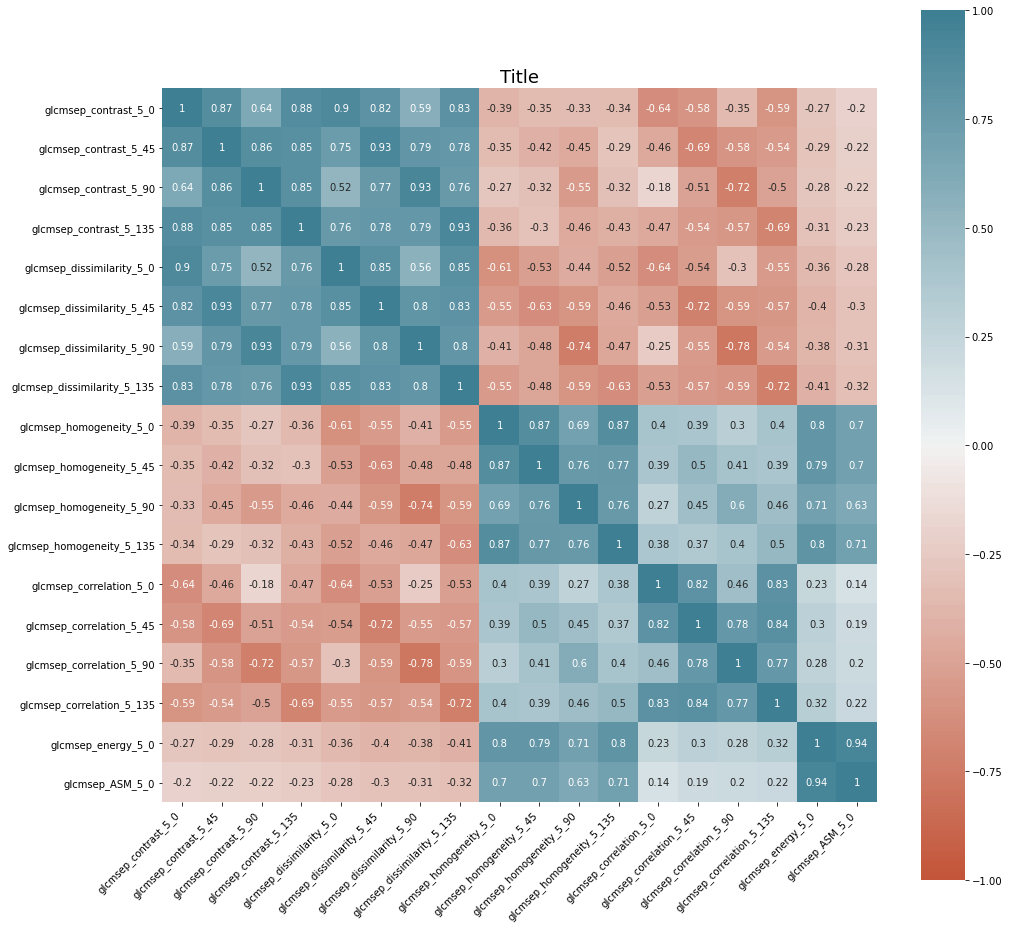

In [35]:
features_of_interest = [name for name in feature_names_in_csv if (name.startswith('glcmsep_'))]

corr = df_features_copy[features_of_interest].corr()

fig_dims = (16, 16)
fig, ax = plt.subplots(figsize=fig_dims)
plt.title(f'Title', fontsize=18)

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, annot=True,
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Text(0, 0.5, 'Count')

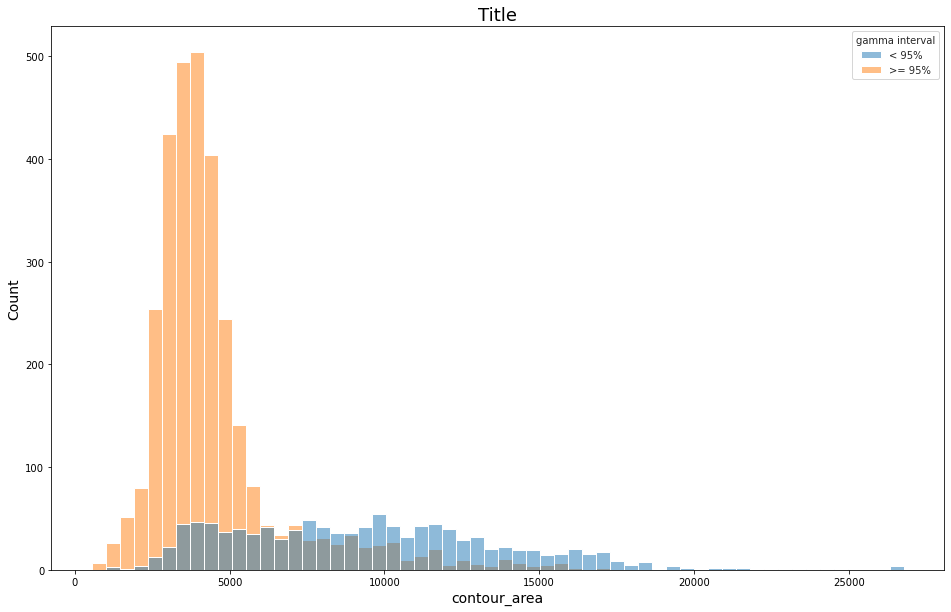

In [36]:
feature = 'contour_area'
fig_dims = (16, 10)
fig, ax = plt.subplots(figsize=fig_dims)
plt.title(f'Title', fontsize=18)

sns.set_style("whitegrid")
ax = sns.histplot(data=df_features_copy, x=feature, hue='gamma interval')
ax.set_xlabel(feature, fontsize=14)
ax.set_ylabel("Count", fontsize=14)

## Compute PCA and t-SNE on texture features

In [37]:
# https://erdem.pl/2020/04/t-sne-clearly-explained
# https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

features_of_interest = [name for name in feature_names_in_csv if (name.startswith('glcmsep_'))]

pca = PCA(n_components=3)
pca_result = pca.fit_transform(df_features_copy[features_of_interest].values)
df_features_copy['1st component'] = pca_result[:,0]
df_features_copy['2nd component'] = pca_result[:,1] 
df_features_copy['3rd component'] = pca_result[:,2]

np.set_printoptions(precision=2, suppress=True)
print('Varianza explicada por 3 componentes principales (%): {}'.format(pca.explained_variance_ratio_*100))

variance = 0.90 # explicar 80% de la varianza
pca2 = PCA(n_components=variance, svd_solver='full')
pca_result2 = pca2.fit_transform(df_features_copy[features_of_interest].values)
print(f"Cantidad de componentes para explicar un {variance*100}% de la varianza: {pca2.n_components_}")

Varianza explicada por 3 componentes principales (%): [88.56  6.43  4.78]
Cantidad de componentes para explicar un 90.0% de la varianza: 2


In [38]:
features_of_interest

['glcmsep_contrast_5_0',
 'glcmsep_contrast_5_45',
 'glcmsep_contrast_5_90',
 'glcmsep_contrast_5_135',
 'glcmsep_dissimilarity_5_0',
 'glcmsep_dissimilarity_5_45',
 'glcmsep_dissimilarity_5_90',
 'glcmsep_dissimilarity_5_135',
 'glcmsep_homogeneity_5_0',
 'glcmsep_homogeneity_5_45',
 'glcmsep_homogeneity_5_90',
 'glcmsep_homogeneity_5_135',
 'glcmsep_correlation_5_0',
 'glcmsep_correlation_5_45',
 'glcmsep_correlation_5_90',
 'glcmsep_correlation_5_135',
 'glcmsep_energy_5_0',
 'glcmsep_ASM_5_0']

<AxesSubplot:xlabel='1st component', ylabel='2nd component'>

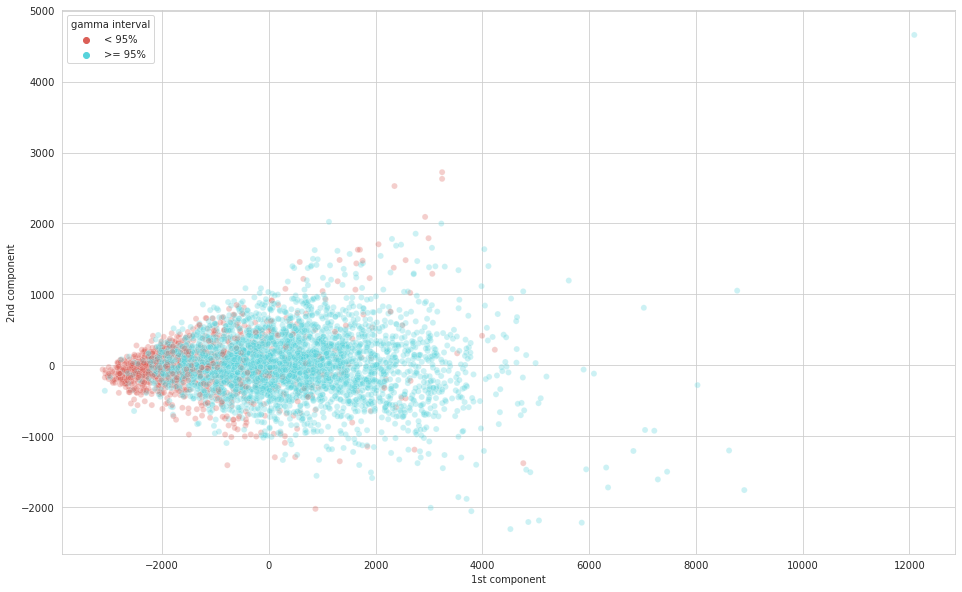

In [39]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="1st component", y="2nd component",
    hue='gamma interval',
    data=df_features_copy,
    legend="full",
    alpha=0.3,
    # palette=sns.color_palette("hls", 2)
    palette=sns.hls_palette(2)
)

In [40]:
import time
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=500, random_state=ARG_SEED)
tsne_results = tsne.fit_transform(df_features_copy[features_of_interest].values)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 4268 samples in 0.002s...
[t-SNE] Computed neighbors for 4268 samples in 0.298s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4268
[t-SNE] Computed conditional probabilities for sample 2000 / 4268
[t-SNE] Computed conditional probabilities for sample 3000 / 4268
[t-SNE] Computed conditional probabilities for sample 4000 / 4268
[t-SNE] Computed conditional probabilities for sample 4268 / 4268
[t-SNE] Mean sigma: 64.895514
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.135273
[t-SNE] KL divergence after 500 iterations: 0.951066
t-SNE done! Time elapsed: 15.240392923355103 seconds


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

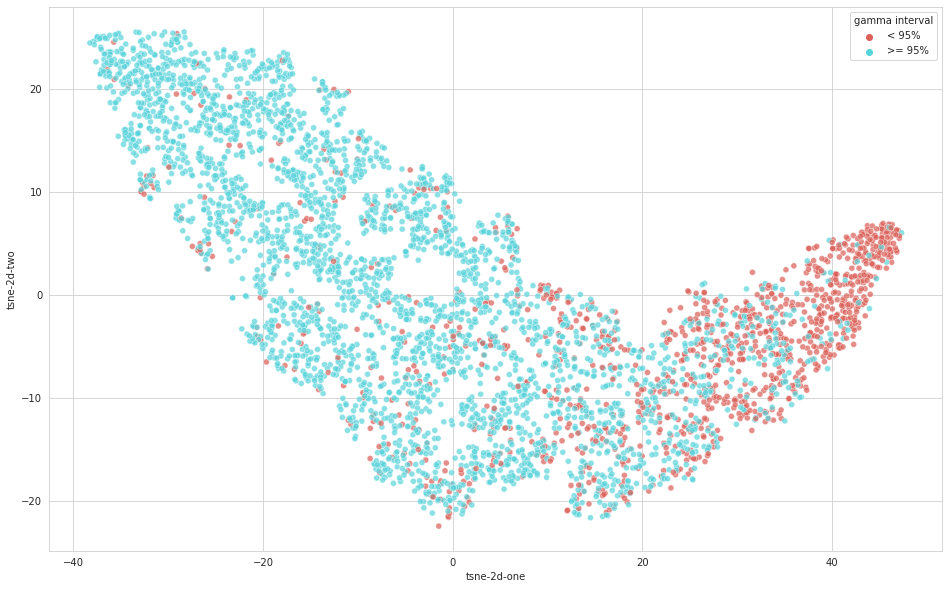

In [41]:
df_features_copy['tsne-2d-one'] = tsne_results[:,0]
df_features_copy['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue='gamma interval',
    palette=sns.hls_palette(2),
    data=df_features_copy,
    legend="full",
    alpha=0.7
)

In [42]:
import xgboost as xgb
print('XGBoost version = {}'.format(xgb.__version__))

XGBoost version = 1.3.3


## Train an XGBoost model with extracted CNN features in 2019+2017
Hago cross-validation usando XGBoost directamente. Para cada métrica se informa, en cada iteración, la media y el desvío standard entre los k folds separados con '+', ej.: **test-rmse:71.88373+1.10987**.

CV con el Learning API (core) soporta early stopping.

In [43]:
# excluir mapas de 2018 para comparar con la CNN presentada en ASTRO:
X = df_features_copy
# Ya no hace falta filtrar por el año 2018 ya que generé el dataset sólo con 2019 y 2017 excluyendo 2018.
# X['year2018'] = [path.find('2018-opencv') != -1 for path in X['jpeg_full_filepath']]
# X = X[~X['year2018']]
y = X['gamma_index']

features_of_interest = feature_names_in_csv # all features extracted so far help to improve performance in validation set.
features_of_interest = [name for name in feature_names_in_csv if not
                        (
                            name.startswith('log-sigma')
                        #or
                        #    name.startswith('wavelet')
                        or
                            name.startswith('gradient')
                        )]

# features_of_interest = [name for name in feature_names_in_csv if name.startswith('original_gldm_')]

X = X[features_of_interest]
print(X.shape, y.shape)

X_train_cv = X
y_train_cv = y
print(X_train_cv.shape, y_train_cv.shape)

dtrain_cv = xgb.DMatrix(data=X_train_cv, label=y_train_cv)
print(f'DMatrix cols: {dtrain_cv.num_col()} rows: {dtrain_cv.num_row()}')

(4268, 470) (4268,)
(4268, 470) (4268,)
DMatrix cols: 470 rows: 4268


In [44]:
features_of_interest

['original_firstorder_10Percentile',
 'original_firstorder_90Percentile',
 'original_firstorder_Energy',
 'original_firstorder_Entropy',
 'original_firstorder_InterquartileRange',
 'original_firstorder_Kurtosis',
 'original_firstorder_MeanAbsoluteDeviation',
 'original_firstorder_Mean',
 'original_firstorder_Range',
 'original_firstorder_RobustMeanAbsoluteDeviation',
 'original_firstorder_RootMeanSquared',
 'original_firstorder_Skewness',
 'original_firstorder_TotalEnergy',
 'original_firstorder_Uniformity',
 'original_firstorder_Variance',
 'original_glcm_Autocorrelation',
 'original_glcm_JointAverage',
 'original_glcm_ClusterProminence',
 'original_glcm_ClusterShade',
 'original_glcm_ClusterTendency',
 'original_glcm_Contrast',
 'original_glcm_Correlation',
 'original_glcm_DifferenceAverage',
 'original_glcm_DifferenceEntropy',
 'original_glcm_DifferenceVariance',
 'original_glcm_JointEnergy',
 'original_glcm_JointEntropy',
 'original_glcm_Imc1',
 'original_glcm_Imc2',
 'original_glc

### Resultados con 2019+2018+2017
**Dataset:** '2019-2018-2017.all-texture-features-dumb.csv'

_train-mae:1.11119+0.00764	test-rmse:3.13041+0.08029	test-mae:1.94695+0.03_
```python
param = {'max_depth': 6 # or 'max_depth': 5 + 'colsample_bytree': 0.3
         , 'eta': 0.05
         , 'objective': 'reg:squarederror'
         , 'eval_metric': ['mae']
         # , 'colsample_bytree': 0.3
         # , 'colsample_bynode': 0.3
         , 'colsample_bylevel' : 0.3
         , 'lambda': 2
         , 'alpha': 2
         # , 'tree_method': 'gpu_hist' # usa la GPU
         , 'min_child_weight': 25
        }
```

### Resultados con 2019+2017
**Dataset:** '2019-2018-2017.all-texture-features-dumb.csv' (excluding 2018)

_[489]	train-rmse:1.27878+0.02592	train-mae:0.90220+0.01639	test-rmse:2.98198+0.14417	test-mae:1.92271+0.07347_
```python
param = {'max_depth': 5 # or 'max_depth': 5 + 'colsample_bytree': 0.3
         , 'eta': 0.05
         , 'objective': 'reg:squarederror'
         , 'eval_metric': ['mae']
         # , 'colsample_bytree': 0.3
         # , 'colsample_bynode': 0.3
         , 'colsample_bylevel' : 0.3
         , 'lambda': 2
         , 'alpha': 2
         # , 'tree_method': 'gpu_hist' # usa la GPU
         , 'min_child_weight': 20
        }
```

### Resultados con 2019+2017
**Dataset:** '2019-2018-2017.pyradiomics-texture-features-contours.csv' (excluding 2018)

_[318]	train-rmse:1.45937+0.03612	train-mae:1.01763+0.02408	test-rmse:2.88731+0.09014	test-mae:1.86241+0.04941_
```python
param = {'max_depth': 6 # or 'max_depth': 5 + 'colsample_bytree': 0.3
         , 'eta': 0.05
         , 'objective': 'reg:squarederror'
         , 'eval_metric': ['mae']
         # , 'colsample_bytree': 0.3
         , 'colsample_bynode': 0.3
         # , 'colsample_bylevel' : 0.3
         , 'lambda': 2
         , 'alpha': 2
         # , 'tree_method': 'gpu_hist' # usa la GPU
         , 'min_child_weight': 20
        }
```

### Resultados con 2019+2017
**Dataset:** '2019-2018-2017.all-texture-features-contours.csv' (excluding 2018)

_[381]	train-rmse:1.16212+0.01242	train-mae:0.81353+0.00677	test-rmse:2.83408+0.05123	test-mae:1.80370+0.03335_
```python
param = {'max_depth': 6 # or 'max_depth': 5 + 'colsample_bytree': 0.3
         , 'eta': 0.05
         , 'objective': 'reg:squarederror'
         , 'eval_metric': ['mae']
         # , 'colsample_bytree': 0.3
         # , 'colsample_bynode': 0.3
         , 'colsample_bylevel' : 0.3
         , 'lambda': 2
         , 'alpha': 2
         # , 'tree_method': 'gpu_hist' # usa la GPU
         , 'min_child_weight': 20
        }
```

### Resultados 2019+2017 con features pyradiomics adicionales:
**original:**
[331]	train-rmse:1.24615+0.03272	train-mae:0.86910+0.01834	test-rmse:2.83952+0.05732	test-mae:1.81501+0.02514

**+gradient:**
[309]	train-rmse:1.18849+0.03703	train-mae:0.82927+0.02396	test-rmse:2.83107+0.07539	test-mae:1.81061+0.04626

**+log-sigma-0:**
[304]	train-rmse:1.13800+0.02842	train-mae:0.79264+0.01719	test-rmse:2.80752+0.07079	test-mae:1.78230+0.04661

**+log-sigma-1:**
[315]	train-rmse:1.15804+0.03244	train-mae:0.80916+0.02217	test-rmse:2.84740+0.05901	test-mae:1.81557+0.03210

**+log-sigma:**
[240]	train-rmse:1.28337+0.04969	train-mae:0.89225+0.03286	test-rmse:2.80367+0.07149	test-mae:1.78147+0.03548

**+wavelet:**
[413]	train-rmse:0.64769+0.01235	train-mae:0.45395+0.00940	test-rmse:2.72473+0.04674	test-mae:1.73198+0.03644

_**Conclusión: remover log-sigma y gradient features**_

In [45]:
param = {'max_depth': 6 # or 'max_depth': 5 + 'colsample_bytree': 0.3
         , 'learning_rate': 0.05
         , 'objective': 'reg:squarederror'
         , 'eval_metric': ['mae']
         # , 'colsample_bytree': 0.3 # related to 'min_child_weight'
         # , 'colsample_bynode': 0.25
         , 'colsample_bylevel' : 0.3
         , 'reg_lambda': 2 # L2 regularization
         , 'reg_alpha': 2 # L1 regularization
         , 'min_split_loss': 0.01
         # , 'tree_method': 'gpu_hist' # usa la GPU
         , 'min_child_weight': 20
        }

In [46]:
print('running cross validation...')
bst = xgb.cv(param, dtrain_cv, nfold=5, num_boost_round=1000, early_stopping_rounds=10, metrics=['rmse', 'mae'],
             seed=ARG_SEED, shuffle=True, verbose_eval=True)

running cross validation...
[0]	train-rmse:90.55845+0.02941	train-mae:90.44143+0.03106	test-rmse:90.55814+0.12461	test-mae:90.44112+0.13125
[1]	train-rmse:86.04309+0.02785	train-mae:85.92459+0.02953	test-rmse:86.04346+0.12521	test-mae:85.92483+0.13206
[2]	train-rmse:81.75367+0.02634	train-mae:81.63334+0.02806	test-rmse:81.75256+0.12230	test-mae:81.63193+0.12926
[3]	train-rmse:77.67864+0.02497	train-mae:77.55640+0.02666	test-rmse:77.67778+0.12264	test-mae:77.55518+0.12979
[4]	train-rmse:73.80741+0.02360	train-mae:73.68304+0.02534	test-rmse:73.80608+0.12221	test-mae:73.68113+0.12956
[5]	train-rmse:70.12985+0.02231	train-mae:70.00317+0.02406	test-rmse:70.12890+0.11981	test-mae:70.00157+0.12730
[6]	train-rmse:66.63639+0.02106	train-mae:66.50704+0.02284	test-rmse:66.63517+0.11825	test-mae:66.50504+0.12601
[7]	train-rmse:63.31775+0.01990	train-mae:63.18554+0.02171	test-rmse:63.31792+0.11655	test-mae:63.18472+0.12448
[8]	train-rmse:60.16523+0.01873	train-mae:60.02991+0.02062	test-rmse:60.1665

[74]	train-rmse:3.12632+0.01625	train-mae:2.70543+0.01155	test-rmse:3.56187+0.05116	test-mae:2.97752+0.04373
[75]	train-rmse:3.04857+0.01636	train-mae:2.62310+0.01266	test-rmse:3.50112+0.04816	test-mae:2.90420+0.04095
[76]	train-rmse:2.97660+0.01765	train-mae:2.54596+0.01296	test-rmse:3.44331+0.04719	test-mae:2.83388+0.03937
[77]	train-rmse:2.90755+0.01605	train-mae:2.47216+0.01164	test-rmse:3.39052+0.04779	test-mae:2.76797+0.03960
[78]	train-rmse:2.84315+0.01443	train-mae:2.40277+0.01041	test-rmse:3.34361+0.04862	test-mae:2.70715+0.04007
[79]	train-rmse:2.78317+0.01285	train-mae:2.33818+0.00947	test-rmse:3.30065+0.04755	test-mae:2.65023+0.03952
[80]	train-rmse:2.72640+0.01350	train-mae:2.27686+0.01024	test-rmse:3.25999+0.04772	test-mae:2.59637+0.04022
[81]	train-rmse:2.67277+0.01670	train-mae:2.21839+0.01221	test-rmse:3.22215+0.04592	test-mae:2.54581+0.03951
[82]	train-rmse:2.62195+0.01595	train-mae:2.16361+0.01190	test-rmse:3.18820+0.04412	test-mae:2.49938+0.03820
[83]	train-rmse:2.5

[149]	train-rmse:1.59542+0.02428	train-mae:1.11864+0.01404	test-rmse:2.76836+0.04431	test-mae:1.78964+0.03242
[150]	train-rmse:1.58961+0.02316	train-mae:1.11438+0.01315	test-rmse:2.76789+0.04489	test-mae:1.78870+0.03263
[151]	train-rmse:1.58267+0.02517	train-mae:1.10948+0.01399	test-rmse:2.76652+0.04610	test-mae:1.78741+0.03282
[152]	train-rmse:1.57632+0.02704	train-mae:1.10494+0.01480	test-rmse:2.76633+0.04610	test-mae:1.78673+0.03261
[153]	train-rmse:1.56915+0.02597	train-mae:1.09981+0.01409	test-rmse:2.76573+0.04729	test-mae:1.78558+0.03350
[154]	train-rmse:1.56198+0.02505	train-mae:1.09471+0.01346	test-rmse:2.76484+0.04718	test-mae:1.78458+0.03363
[155]	train-rmse:1.55550+0.02487	train-mae:1.09007+0.01354	test-rmse:2.76415+0.04704	test-mae:1.78357+0.03368
[156]	train-rmse:1.54872+0.02555	train-mae:1.08534+0.01385	test-rmse:2.76322+0.04679	test-mae:1.78250+0.03310
[157]	train-rmse:1.54115+0.02457	train-mae:1.08000+0.01358	test-rmse:2.76182+0.04610	test-mae:1.78093+0.03318
[158]	trai

[224]	train-rmse:1.20077+0.02127	train-mae:0.84237+0.01045	test-rmse:2.74335+0.04619	test-mae:1.75432+0.03516
[225]	train-rmse:1.19548+0.02117	train-mae:0.83887+0.01055	test-rmse:2.74265+0.04576	test-mae:1.75404+0.03511
[226]	train-rmse:1.19119+0.02156	train-mae:0.83592+0.01081	test-rmse:2.74256+0.04665	test-mae:1.75389+0.03521
[227]	train-rmse:1.18766+0.01988	train-mae:0.83355+0.00985	test-rmse:2.74206+0.04670	test-mae:1.75368+0.03567
[228]	train-rmse:1.18216+0.02018	train-mae:0.82981+0.01005	test-rmse:2.74166+0.04671	test-mae:1.75349+0.03548
[229]	train-rmse:1.17741+0.01931	train-mae:0.82656+0.00922	test-rmse:2.74103+0.04618	test-mae:1.75285+0.03550
[230]	train-rmse:1.17381+0.01864	train-mae:0.82413+0.00879	test-rmse:2.74122+0.04627	test-mae:1.75307+0.03555
[231]	train-rmse:1.17022+0.01761	train-mae:0.82164+0.00795	test-rmse:2.74114+0.04567	test-mae:1.75286+0.03545
[232]	train-rmse:1.16656+0.01651	train-mae:0.81913+0.00736	test-rmse:2.74063+0.04551	test-mae:1.75257+0.03524
[233]	trai

[299]	train-rmse:0.93282+0.01188	train-mae:0.65565+0.00773	test-rmse:2.72986+0.04649	test-mae:1.73985+0.03671
[300]	train-rmse:0.92977+0.01254	train-mae:0.65346+0.00835	test-rmse:2.72991+0.04633	test-mae:1.73988+0.03656
[301]	train-rmse:0.92738+0.01292	train-mae:0.65185+0.00853	test-rmse:2.72980+0.04633	test-mae:1.73976+0.03675
[302]	train-rmse:0.92354+0.01193	train-mae:0.64918+0.00775	test-rmse:2.72982+0.04629	test-mae:1.73958+0.03706
[303]	train-rmse:0.92143+0.01126	train-mae:0.64765+0.00714	test-rmse:2.72976+0.04594	test-mae:1.73937+0.03698
[304]	train-rmse:0.91887+0.01070	train-mae:0.64567+0.00674	test-rmse:2.72964+0.04612	test-mae:1.73925+0.03709
[305]	train-rmse:0.91635+0.01041	train-mae:0.64389+0.00654	test-rmse:2.72972+0.04602	test-mae:1.73939+0.03694
[306]	train-rmse:0.91390+0.01082	train-mae:0.64220+0.00687	test-rmse:2.72928+0.04625	test-mae:1.73902+0.03701
[307]	train-rmse:0.91052+0.01133	train-mae:0.63978+0.00669	test-rmse:2.72945+0.04640	test-mae:1.73928+0.03695
[308]	trai

[374]	train-rmse:0.73213+0.01069	train-mae:0.51386+0.00831	test-rmse:2.72625+0.04729	test-mae:1.73343+0.03672
[375]	train-rmse:0.73009+0.01117	train-mae:0.51238+0.00859	test-rmse:2.72620+0.04730	test-mae:1.73343+0.03689
[376]	train-rmse:0.72811+0.01145	train-mae:0.51097+0.00870	test-rmse:2.72618+0.04723	test-mae:1.73332+0.03699
[377]	train-rmse:0.72547+0.01204	train-mae:0.50904+0.00911	test-rmse:2.72641+0.04722	test-mae:1.73343+0.03696
[378]	train-rmse:0.72364+0.01227	train-mae:0.50772+0.00931	test-rmse:2.72651+0.04744	test-mae:1.73345+0.03720
[379]	train-rmse:0.72197+0.01265	train-mae:0.50648+0.00963	test-rmse:2.72651+0.04738	test-mae:1.73337+0.03724
[380]	train-rmse:0.71971+0.01262	train-mae:0.50491+0.00963	test-rmse:2.72647+0.04720	test-mae:1.73318+0.03731
[381]	train-rmse:0.71775+0.01230	train-mae:0.50342+0.00947	test-rmse:2.72646+0.04726	test-mae:1.73309+0.03737
[382]	train-rmse:0.71594+0.01222	train-mae:0.50205+0.00945	test-rmse:2.72632+0.04726	test-mae:1.73286+0.03721
[383]	trai

TODO: generar nuevo dataset '2019-2018-2017.texture-features-contours.csv' que incluya los features pyradiomics generados con contorno y los features glcm usando scikit-image.

In [47]:
bst

,train-rmse-mean,train-rmse-std,train-mae-mean,train-mae-std,test-rmse-mean,test-rmse-std,test-mae-mean,test-mae-std
0,90.558453,0.029411,90.441429,0.031065,90.558139,0.124608,90.441121,0.131254
1,86.043092,0.027853,85.924594,0.029526,86.043458,0.125214,85.924829,0.132064
2,81.753670,0.026336,81.633345,0.028057,81.752557,0.122305,81.631932,0.129259
3,77.678642,0.024970,77.556398,0.026657,77.677779,0.122642,77.555176,0.129786
4,73.807414,0.023601,73.683043,0.025344,73.806078,0.122206,73.681131,0.129557
...,...,...,...,...,...,...,...,...
400,0.676064,0.012097,0.473825,0.009375,2.724331,0.045883,1.731670,0.036106
401,0.673934,0.012313,0.472298,0.009564,2.724325,0.046053,1.731653,0.036114
402,0.671627,0.012650,0.470701,0.009743,2.724328,0.046261,1.731666,0.036127
403,0.669293,0.012939,0.469137,0.009871,2.724297,0.046074,1.731741,0.036145


In [93]:
def save_best_model(model_file):
    best_score = float('inf')
    
    def callback(env):
        nonlocal best_score
        if env.evaluation_result_list[-1][1] < best_score:
            env.model.save_model(model_file)
            best_score = env.evaluation_result_list[-1][1]
            
    return callback;

In [94]:
class SaveBestModel(xgb.callback.TrainingCallback):
    '''Save model after iteration if MAE improved.
    '''
    def __init__(self, model_file):
        self.best_score = float('inf')
        self.model_file = model_file

    def _get_key(self, data, metric):
        return f'{data}-{metric}' # ex.: train-mae, valid-mae

    def after_iteration(self, model, epoch, evals_log):
        '''Update the plot.'''
        # print(evals_log['valid']['mae'][-1])
        # len(data) == 2, len(metric) == 1
        #for data, metric in evals_log.items():
        #    for metric_name, log in metric.items():
        #        key = self._get_key(data, metric_name)
        #        print(epoch, key, log[-1]) # print latest metric value
        current_score = evals_log['valid']['mae'][-1]
        if current_score < self.best_score:
            model.save_model(self.model_file)
            self.best_score = current_score
            
        
        # False to indicate training should not stop.
        return False

In [179]:
def savePredictionsDataframe(modelName, fileAndGamma, predictions, fold, part):

    lst = lst = [(row[0], row[1]) for row in fileAndGamma.values]
    lst2 = [(e[0], e[1], p) for e, p in zip(lst, predictions)]

    # armar un pandas dataframe con el test set completo
    df = pd.DataFrame(lst2, columns=['filename', 'actual gamma', 'predicted gamma'])
    dir = os.path.join(ARG_SOURCE_PATH, "predictions")
    predictions_file_path = '{}/predicted_gamma_{}.{}.{}.csv'.format(dir, modelName, fold, part)
    df.to_csv(predictions_file_path, index=False)
    print(f'Predictions on {part} saved to {predictions_file_path}\n')
    
    return df

In [180]:
X = df_features_copy
X = shuffle(X, random_state=ARG_SEED)
dfFileAndGamma = X[['jpeg_full_filepath', 'gamma_index']]

y = X['gamma_index']
X = X[features_of_interest]
print(X.shape, y.shape)

y2_valid = np.array([])
y2_valid_hat = np.array([])
y2_train = np.array([])
y2_train_hat = np.array([])

feat_importance_weight_dict = {}
feat_importance_gain_dict = {}

k_fold = KFold(5, shuffle=True, random_state=ARG_SEED)
for k, (train, valid) in enumerate(k_fold.split(X, y)):
    # save best model file per fold
    MODEL_FILE = os.path.join(ARG_SOURCE_PATH, f'models/best-xgboost.model.{k}')
    myCallback = SaveBestModel(MODEL_FILE)
        
    # preseleccion de genes con todos los casos (anteriormente se hizo en la partición de training)
    X_train = X.iloc[train]
    y_train = y.iloc[train]
    X_valid = X.iloc[valid]
    y_valid = y.iloc[valid]
    
    dtrain = xgb.DMatrix(data=X_train, label=y_train)
    dvalid = xgb.DMatrix(data=X_valid, label=y_valid)

    # specify validations set to watch performance
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
    results = {}
    bst = xgb.train(param, dtrain, num_boost_round=1000, evals=watchlist, early_stopping_rounds=10, evals_result=results,
                    callbacks=[myCallback], verbose_eval=False)    
    best_iteration = bst.best_iteration
    best_score = bst.best_score
    
    bst = xgb.Booster()  # init model
    bst.load_model(MODEL_FILE)  # load data

    # This is prediction
    y_valid_hat = bst.predict(dvalid)
    y_train_hat = bst.predict(dtrain)
    
    y2_valid = np.concatenate((y2_valid, y_valid))
    y2_valid_hat = np.concatenate((y2_valid_hat, y_valid_hat))
    y2_train = np.concatenate((y2_train, y_train))
    y2_train_hat = np.concatenate((y2_train_hat, y_train_hat))
    
    # correlación entre predichos y observados per fold
    corr_valid = np.corrcoef(y_valid, y_valid_hat)[0, 1]
    corr_train = np.corrcoef(y_train, y_train_hat)[0, 1]
    mae_valid = mean_absolute_error(y_valid, y_valid_hat)
    mae_train = mean_absolute_error(y_train, y_train_hat)
    r2score_valid = r2_score(y_valid, y_valid_hat)
    r2score_train = r2_score(y_train, y_train_hat)

    print("[fold {0}] best iter {1}; best score {2}; PCC ({3:.3f}, {4:.3f}); MAE ({5:.5f}, {6:.5f}); R^2 ({7:.3f}, {8:.3f})".
          format(k, best_iteration, best_score, corr_train, corr_valid, mae_train, mae_valid, r2score_train, r2score_valid))
       
    savePredictionsDataframe('xgboost', dfFileAndGamma.iloc[valid], y_valid_hat, k, 'validation')
        
    d_weight = bst.get_fscore() # importance_type='weight'
    d_gain = bst.get_score(importance_type='gain')
    # d = bst.get_score(importance_type='total_gain')
    # print(f'No. of most important features: {len(d)}')
    # xgb.plot_importance(d, max_num_features=5)
    # sorted_dict = {k: v for k, v in sorted(d.items(), key=lambda kv: kv[1], reverse=True)}
    # df_importance = pd.DataFrame.from_dict(sorted_dict, orient='index', columns=['importance'])
    # print(df_importance.head(10))

    if feat_importance_weight_dict == {}:
        feat_importance_weight_dict = d_weight
    else:
        for k, v in d_weight.items():
            if k in feat_importance_weight_dict:
                feat_importance_weight_dict[k] += v
            else:
                feat_importance_weight_dict[k] = v

    if feat_importance_gain_dict == {}:
        feat_importance_gain_dict = d_gain
    else:
        for k, v in d_gain.items():
            if k in feat_importance_gain_dict:
                feat_importance_gain_dict[k] += v
            else:
                feat_importance_gain_dict[k] = v
                
    
# correlación entre predichos y observados all folds
corr_valid = np.corrcoef(y2_valid, y2_valid_hat)[0, 1]
corr_train = np.corrcoef(y2_train, y2_train_hat)[0, 1]
mae_valid = mean_absolute_error(y2_valid, y2_valid_hat)
mae_train = mean_absolute_error(y2_train, y2_train_hat)
r2score_valid = r2_score(y2_valid, y2_valid_hat)
r2score_train = r2_score(y2_train, y2_train_hat)

print("\nPCC ({0:.3f}, {1:.3f}); MAE ({2:.5f}, {3:.5f}); R^2 ({4:.3f}, {5:.3f})\n".
      format(corr_train, corr_valid, mae_train, mae_valid, r2score_train, r2score_valid))
    
sorted_dict = {k: v for k, v in sorted(feat_importance_weight_dict.items(), key=lambda kv: kv[1], reverse=True)}
df_importance = pd.DataFrame.from_dict(sorted_dict, orient='index', columns=['weight'])
df_importance.head(25)

(4268, 470) (4268,)
[fold 0] best iter 239; best score 1.819751; PCC (0.973, 0.808); MAE (0.79772, 1.81975); R^2 (0.942, 0.653)
Predictions on validation saved to /hdd/data/radioterapia/ciolaplata/predictions/predicted_gamma_xgboost.0.validation.csv

[fold 1] best iter 255; best score 1.778833; PCC (0.973, 0.817); MAE (0.78384, 1.77883); R^2 (0.942, 0.662)
Predictions on validation saved to /hdd/data/radioterapia/ciolaplata/predictions/predicted_gamma_xgboost.1.validation.csv

[fold 2] best iter 230; best score 1.70349; PCC (0.970, 0.836); MAE (0.84176, 1.70349); R^2 (0.934, 0.698)
Predictions on validation saved to /hdd/data/radioterapia/ciolaplata/predictions/predicted_gamma_xgboost.2.validation.csv

[fold 3] best iter 267; best score 1.759547; PCC (0.977, 0.802); MAE (0.73643, 1.75955); R^2 (0.951, 0.642)
Predictions on validation saved to /hdd/data/radioterapia/ciolaplata/predictions/predicted_gamma_xgboost.3.validation.csv

[fold 4] best iter 309; best score 1.670073; PCC (0.983, 

,weight
original_gldm_LargeDependenceLowGrayLevelEmphasis,232
wavelet-LH_firstorder_Kurtosis,202
original_glszm_GrayLevelVariance,196
wavelet-LH_firstorder_Skewness,190
wavelet-LH_glszm_ZoneEntropy,189
wavelet-LH_gldm_DependenceVariance,184
wavelet-LL_firstorder_Range,182
original_glrlm_ShortRunEmphasis,174
wavelet-LL_glszm_SmallAreaLowGrayLevelEmphasis,172
wavelet-HL_firstorder_Mean,168


In [181]:
sorted_dict = {k: v for k, v in sorted(feat_importance_gain_dict.items(), key=lambda kv: kv[1], reverse=True)}
df_importance = pd.DataFrame.from_dict(sorted_dict, orient='index', columns=['gain'])
df_importance['gain'] = df_importance['gain'].map('{:.0f}'.format)
df_importance.head(25)

,gain
original_glszm_ZoneVariance,10164
wavelet-LL_glcm_DifferenceAverage,7626
original_glszm_LargeAreaEmphasis,6613
original_glszm_LargeAreaLowGrayLevelEmphasis,6414
wavelet-LH_ngtdm_Coarseness,6317
wavelet-LL_gldm_SmallDependenceEmphasis,6175
original_gldm_SmallDependenceEmphasis,5891
original_glszm_ZonePercentage,4966
glcmsep_dissimilarity_5_0,4240
original_glcm_DifferenceAverage,4019
